# Tutorial

## Basics

## WEAVE objects

* An OB holds all the information that purtains to making an observation: the targets, the conditions, the instrument configuration. You can locate specific OBs with their obid `data.obs[obid]`

* An Exposure is one integration of both arms of the spectrograph. You can locate Exposures like so:  `data.exposures[mjd]`

* A Run is a weave term for an exposure taken in one arm of the spectrograph (so there are always 2 Runs per Exposure). You can locate runs using their runid `data.runs[runid]` or their colour relative to the exposure `data.exposures[mjd].runs['red']`

* A `spectrum` in weaveio refers to a single spectrum of a single target (not the block of `spectr*a*`)

* An L1 product refers to the spectra recorded in an L1File. All L1 data is separated by camera colour (red and blue). 
    * A single spectrum is the processed spectrum from the raw data
    * A stacked spectrum is the spectrum resulting from stacking two or more single spectra in a single ob
    * A superstacked spectrum results from stacking *between* OBs but with the same instrument configuration
    * A supertarget spectrum results from stacking every single spectrum of a single WeaveTarget cname.

* There are three types of `Target`
    1. `WeaveTarget` is the unified target based on ra, dec. They have a unique CNAME
    2. `SurveyTarget` is a target specified by a survey in a surveycatalogue (they reference a single WeaveTarget). These are unique to a catalogue.
    3. `FibreTarget` is a result of assigning a spectrograph `Fibre` to a `SurveyTarget`. These are unique to an OBSpec.
    

### What is an attribute? What is an object? What is a product?

* weave.io is an object orientated query language using a neo4j database hosted at lofar.herts.ac.uk. 
* weave.io stores 4 (+1) types of object:
    1. File - A reference to a physical fits file on the herts system (it also stores references to individual fits.HDUs and their headers as separate objects, but the user doesn't need to know of their existence to use weave.io)
    2. Object - A object that references a concept in the WEAVE universe that has attributes (an OB object has an obid attribute, an exposure object has an attribute expmjd
    3. Attribute - A piece of data that belongs to some object
    4. Product - A special type of attribute which references binary data not stored in the database itself (e.g. spectrum flux)

## If confused, ignore...

### object/attribute 
weave.io uses Python syntax to traverse a hierarchy of objects and their attributes. It is important to note that one object can be an attribute of another object (e.g. a run is an attribute of an OB). 

You can stitch together these objects to form a hierarchy of objects:

run <-- exposure <-- ob <--obspec

Every OB is a parent of multiple Exposures which in turn are parents exactly 2 runs each (one red, one blue).

Because of this chain of parentage/relation, every object has access to all attributes where there is a chain, as if they were its own attributes.

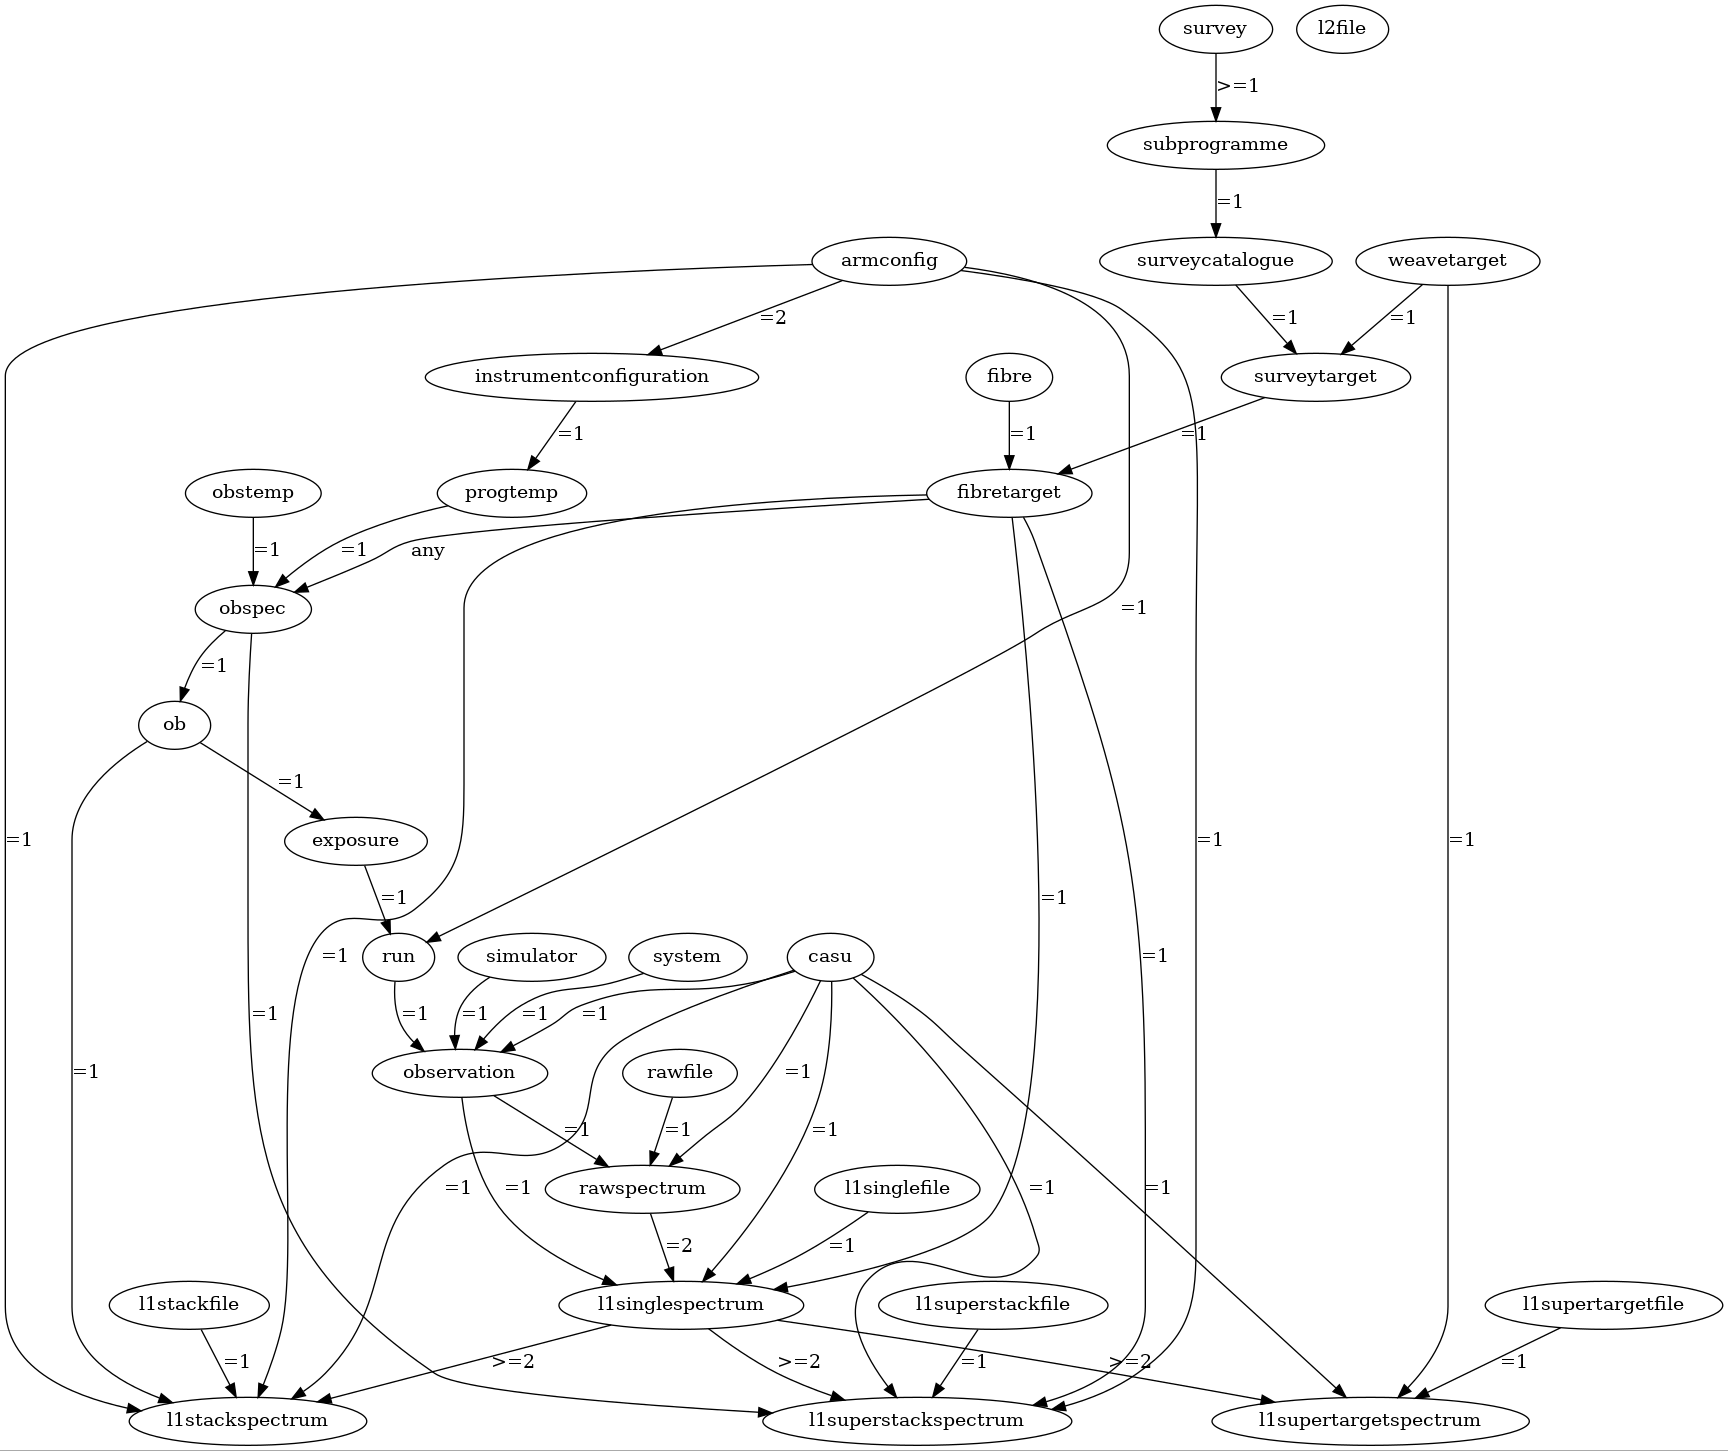

### Traversal syntax 

1. You can request any directly owned attribute of an object 
    * An OB has an obid: `ob.obid`
    * An obstemp has a maxseeing `obstemp.maxseeing` 
    
1. You can request any attribute of objects that are further away in the hierarchy as if it were its own. This is useful because a priori you wouldn't be expected to know where any particular piece of data is stored, just that it exists.
    * `run.maxseeing` is identical to `run.exposure.ob.obspec.obstemp.maxseeing`

1. Traversal works in any direction
    * You can go down a hierarchy: `exposure.run.rawspectrum`
    * You can go up as well: `rawspectrum.run.exposure`

1. Traversal can be implicit like with the indirectly accessed attributes above
    * You can skip out stages: `run.obspec` is identical to `run.ob.obspec`
    
1. Traversal requires you to be aware of plurality/multiplicity (neo4j calls this cardinality):
    * A run only ever has a single ob, so you query it using a singular name: `run.ob`
    * But an ob will typically have multiple runs, so you must use plural names: `ob.runs`
    * weave.io is aware of plurality of the whole hierarchy, so it will shout at you if you are obviously wrong: `ob.run` will fail before you even execute the query.

1. Traversal name plurality is relative
    * A run has a single ob, which in turn has multiple runs: `run.ob.runs` will return all runs of the ob (including the one that was explicitly referenced at the start. 
    * `ob.runs.weavetarget.obs` can be read as "**For each** of the runs, get its weavetarget, and then **for each** weavetarget get all OBs which assign a fibre to that target.

1. Traversal using dot syntax always increases/maintains the total number of rows returned at the end
    * A consequence of traversal is the building up of rows. This is useful to get properly aligned labels/indexes for things.
    * `ob.runs.ob.runs.ob.runs` will return not simply return the runs of this ob, but rather a huge duplicated list because each time you use the '.' syntax, we are saying **"for each"**


### Identifiers

1. You can request a specific object if you know its id 
    * `one_ob = data.obs[obid]` 
    * `a_list_of_obs = data.obs[[obid1, obid2, obid3]]` 
    * Plurality still applies here: `data.weavetargets.obs[obid]` will return one ob **for each** weavetarget
        * `data.obs[obid].weavetargets` returns all weavetargets for this particular ob
        * `data.weavetargets.obs[obid]` returns the ob with obid for each weavetarget (sometimes will be None)

1. Relative identifiers
    * `exposure.runs['red']` is functionally the same as `exposure.runs[runid]` (where runid is the red one)

### Exploration

You can use the `attributes()` function to see what information is available for a given object:

    >>> attributes(ob)
    ['obid', 'runids', 'expmjds', 'maxseeing', 'targprogs', 'ras', 'decs', ... (a lot lot more)]
    
Likewise, use the `objects()` function for related objects:
    
    >>> objects(ob)
    ['exposures', 'runs', 'obspec', 'progtemp', ...]

### Running a query
A query finds the locations of all the L1/L2/Raw products that you want. 
It is analagous to an SQL query except that it is written in Python.

* A query is constructed using python like so:

    ```
    from weaveio import Data
    data = Data(username, password)
    
    runs = data.obs[obid].runs
    reds = runs[runs.colour == 'red']
    spectra = reds.l1singlespectra
    ```
    `runs`, `reds`, `spectra` are all queries
* Each part of this query can be run independently, using the parentheses:
    * `runs.runids` is still a query 
    * `runs.runids()` returns a actual list of numbers
    * `reds()` will return a list of Run objects (containing all attributes of a run)
    * `spectra()` will return a spectra object (read from the fits file on herts.ac.uk) which contains the flux, wvls etc

# Examples of use:

# 1. I want to return the number of sky spectra in a given run (runid=1002813)

In [ ]:
runid = 1002813
nsky = sum(data.runs[runid].targuse == 'S')

# 2. I want to plot all single sky spectra from last night in the red arm

In [ ]:
yesterday = 59193
q_singlespectra = data.singlespectra

q_is_red = singlespectra.camera == 'red'
q_observed_yesterday = floor(singlespectra.expmjd) == yesterday
q_is_sky_target = singlespectra.targuse == 'S'

q_red_singlespectra = singlespectra[is_red & observed_yesterday & is_sky_target]

spectra = q_red_singlespectra()  # execute the query and return a spectrum object

# matplotlib
plt.plot(spectra.wvls, spectra.flux)

# 3. I want to plot the H-alpha flux vs. L2 redshift distribution from all WL or W-QSO targets that were observed  from all OBs observed in the past month. Use the stacked data

In [ ]:
obs = data.obs[data.obs.startmjd >= 59163]
fibretargets = obs.fibretargets[any(obs.fibretargets.surveys == 'WL') | any(obs.fibretargets.surveys == 'WQSO')]

l2rows = fibretargets.stacked12
table = l2rows[['halpha', 'zbest']]()

plt.scatter(table['halpha'], table['zbest'])

# 4. I want to identify the WL spectrum with the brightest continuum at 5000AA and plot the spectrum from both red and blue arms, together with the error (variance) spectrum. 

In [ ]:
stackedspectra = data.stackedspectra  # lots of different stacked spectra from many different OBs
wl_stackedspectra = stackedspectra[any(stackedspectra.surveys == 'WL')]

reds = wl_stackedspectra[wl_stackedspectra.camera == 'red']
blues = wl_stackedspectra[wl_stackedspectra.camera == 'blue']

continuum = []
for red, blue in reds(), blues():  # this loop is offline
    continuum.append(my_special_module.median_flux(red, blue 4950, 5050))  # do some fancy function you have written
index = np.argmax(continuum)


red = reds[index]()
blue = blues[index]()
plt.plot(red.wvls, red.flux)
plt.plot(blue.wvls, blue.flux)

plt.plot(red.wvls,  1 / red.ivar, label='variance')
plt.plot(blue.wvls, 1 /  blue.ivar, label='variance')

# 5. Get the brightest g-band target in an OB and plot some spectra 
a. I would like to identify the brightest (g band) WL spectrum observed in an OB with `obid=1234` (using the g band magnitude in the stacked spectrum). Plot the stack, in both red and blue arms (on same plot)

b. Plot the individual spectra that went into making the stack. 

d. I would like to search for any other OB that contains the same astronomical object. Overplot the single spectra that were observed in those OBs

In [ ]:
import matplotlib.pyplot as plt


####### < Part A
ob = data.obs[1234]  # get the ob 

# all L2 data that used stackedspectra.
stackedl2 = ob.stackedl2

# return rows in the L2 dataset that correspond to a lofar target
lofar_l2 = stackedl2[any(stackedl2.surveys == 'WL')]  # each target can belong to more than one survey
l2row = lofar_l2[lofar_l2.mag_gs == max(lofar_l2.mag_gs)]  # get the one row that corresponds to the brightest lofar target

# now we jump from L2 rows to the stack spectra
brightest_red = l2row.stackedspectra[l2row.stackedspectra.camera == 'red']
brightest_blue = l2row.stackedspectra[l2row.stackedspectra.camera == 'blue']

# Now plot the actual data
fig, (redax, blueax) = plt.subplots()
redax.plot(brightest_red.wvls(), brightest_red.flux(), 'r-', label='brightest')
blueax.plot(brightest_blue.wvls(), brightest_blue.flux(), 'b-', label='brightest')
####### Part A />


####### < Part B
# now locate the indivdual single spectra that were stacked
red_spectra = brightest_red.singlespectra
blue_spectra = brightest_blue.singlespectra

# matplotlib allows you to plot multiple lines with 2d arrays
redax.plot(redsingle.wvls(), redsingle.flux(), 'r-', alpha=0.4, label='single for brightest')
blueax.plot(bluesingle.wvls(), bluesingle.flux(), 'r-', alpha=0.4, label='single for brightest')
####### Part B />


####### < Part C
# Now get all other stacked spectra that were observed for this target, no matter the OB
brightest_target = l2row.weavetarget
other_reds = brightest_target.stackedspectra[brightest_target.stackedspectra.camera == 'red']
other_blues = brightest_target.stackedspectra[brightest_target.stackedspectra.camera == 'blue']

# overplot the other observations
for wvl, flux in other.red.wvls(), other_red.flux():
    redax.plot(wvl, flux, 'k:', alpha=0.2, label='from all obs')
####### Part C />

# Demo

## 6. I would like to identify all of the sky spectra in an OB used to create the sky model spectrum for that OB. I would then like to compare that list to the list of spectra denoted to be used as sky in the input OB to determine how many extra or fewer sky spectra were used in the combination. 

## Rohit's question

I'm interested in getting the spectra for the AGN sample (specifically the LERGs) from the SV input, looking for sources between a redshift range, say 0.5 < z < 1 (or 1.4, whichever is the upper limit), and analysing their continuum. 

I'm also interested in using emission line properties to perform source classifications

1. select redshift 0.5 - 1
1. get LERGs:
    * $\log ([O III]/Hβ) - 1/3 \log ([N II]/Hα) + \log ([S II]/Hα) + \log ([O I]/Hα)$
1. get stacked spectra

* Need `FLUX_EL_W` and `ERR_FLUX_EL_W` columns from L2 data, where EL is the emission line and W its wavelength

In [ ]:
def excitation_index(oiii, hb, nii, sii, oi, Hα):
    return log(oiii/Hβ) - (log(nii/Hα) / 3) + log(sii/Hα) + log(oi/Hα)

stackedl2 = data.stackedl2
redshift = stackedl2.z
EI = excitation_index(stackedl2.flux_oiii_5007, stackedl2.flux_hbeta, stackedl2.flux_nii_6583, stackedl2.flux_oi_6300, 
                      stackedl2.flux_sii_6716, stackedl2.flux_halpha)

in_redshift_range = (stackedl2.zbest > 0.5) & (stackedl2.zbest < 1.)
is_lerg = EI < 0.95  

spectra = stackedl2[in_redshift_range & is_lerg].stackedspectra
reds = spectra[spectra.camera == 'red']
blues = spectra[spectra.camera == 'blue']

plt.plot(reds.wvls(), reds.flux())
plt.plot(blue.wvls(), blue.flux())

# Anniek's fluxes and other catalogues
We can add any catalogue or file we like to the database, all that is required is a precise knowledge of what data was used to create the catalogue/file (so we can associate it correctly). 

## Find all reprocessed Ha flux done by Anniek for a given OB

In [ ]:
data.ob.anniek.flux_halpha

## Join your own catalogue based on cname

In [ ]:
catalogue = read_my_nice_catalogue('...')   # has a cname column
data.join(catalogue, 'cname', weavetarget.cname, name='my_catalogue')  # only exists for this session

## Join your own file that reprocessed data from a specific file (like Anniek's)

In [ ]:
line_fluxes = read_line_fluxes('...')  # from the weave single spectra associated with run 100423 
data.join(line_fluxes, 'index', data.runs[100423].singlespectra, name='line_fluxes')